<a href="https://colab.research.google.com/github/ANKIT-KANDULNA/CS318_DL-LAB/blob/main/Experiment-2/DL_lab_exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import and Dataset Loading

In [1]:
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# Load MNIST
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

val_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 53.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.78MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.41MB/s]


Helper Functions (Normalization & One-Hot Encoding)

In [3]:
def normalize(x):
    return x / 255.0

def one_hot(labels, num_classes=10):
    one_hot_labels = np.zeros((labels.size, num_classes))
    one_hot_labels[np.arange(labels.size), labels] = 1
    return one_hot_labels

Activation Functions

In [4]:
class Activations:

    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x):
        return (x > 0).astype(float)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def sigmoid_derivative(x):
        s = Activations.sigmoid(x)
        return s * (1 - s)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def tanh_derivative(x):
        return 1 - np.tanh(x) ** 2

    @staticmethod
    def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

Neural Network Class (From Scratch)

In [15]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activation='relu', lr=0.01):
        self.layer_sizes = layer_sizes
        self.lr = lr
        self.activation = activation
        self.params = {}
        self.cache = {}
        self.grads = {}

        self._init_weights()

    def _init_weights(self):
        for i in range(len(self.layer_sizes) - 1):
            self.params[f'W{i}'] = np.random.randn(
                self.layer_sizes[i], self.layer_sizes[i+1]
            ) * 0.01
            self.params[f'b{i}'] = np.zeros((1, self.layer_sizes[i+1]))

    def forward(self, X):
        self.cache['A0'] = X

        for i in range(len(self.layer_sizes) - 2):
            Z = self.cache[f'A{i}'] @ self.params[f'W{i}'] + self.params[f'b{i}']
            self.cache[f'Z{i+1}'] = Z

            if self.activation == 'relu':
                A = Activations.relu(Z)
            elif self.activation == 'sigmoid':
                A = Activations.sigmoid(Z)
            else:
                A = Activations.tanh(Z)

            self.cache[f'A{i+1}'] = A

        # Output layer
        ZL = self.cache[f'A{len(self.layer_sizes)-2}'] @ self.params[f'W{len(self.layer_sizes)-2}'] + self.params[f'b{len(self.layer_sizes)-2}']
        self.cache['ZL'] = ZL
        AL = Activations.softmax(ZL)
        self.cache['AL'] = AL

        return AL

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

    def backward(self, y_true):
        m = y_true.shape[0]
        dZ = self.cache['AL'] - y_true

        for i in reversed(range(len(self.layer_sizes) - 1)):
            A_prev = self.cache[f'A{i}']
            self.grads[f'dW{i}'] = (A_prev.T @ dZ) / m
            self.grads[f'db{i}'] = np.sum(dZ, axis=0, keepdims=True) / m

            if i > 0:
                W = self.params[f'W{i}']
                dA_prev = dZ @ W.T
                Z_prev = self.cache[f'Z{i}']

                if self.activation == 'relu':
                    dZ = dA_prev * Activations.relu_derivative(Z_prev)
                elif self.activation == 'sigmoid':
                    dZ = dA_prev * Activations.sigmoid_derivative(Z_prev)
                else:
                    dZ = dA_prev * Activations.tanh_derivative(Z_prev)


    def update_parameters(self):
        for i in range(len(self.layer_sizes) - 1):
            self.params[f'W{i}'] -= self.lr * self.grads[f'dW{i}']
            self.params[f'b{i}'] -= self.lr * self.grads[f'db{i}']


    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def evaluate(self, X, y):
        preds = self.predict(X)
        return np.mean(preds == y)


def train(model, train_loader, val_loader, epochs=5):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        train_loss, train_correct, total = 0, 0, 0

        for images, labels in train_loader:
            images = images.cpu().numpy().reshape(images.shape[0], -1)
            labels_np = labels.cpu().numpy()

            images = normalize(images)
            y_onehot = one_hot(labels_np)

            preds = model.forward(images)
            loss = model.compute_loss(y_onehot, preds)
            model.backward(y_onehot)
            model.update_parameters()

            train_loss += loss * images.shape[0]
            train_correct += np.sum(np.argmax(preds, axis=1) == labels_np)
            total += images.shape[0]

        train_acc = train_correct / total
        train_loss /= total

        val_acc = 0
        val_loss = 0
        total = 0

        for images, labels in val_loader:
            images = images.cpu().numpy().reshape(images.shape[0], -1)
            labels_np = labels.cpu().numpy()
            images = normalize(images)

            y_onehot = one_hot(labels_np)
            preds = model.forward(images)

            val_loss += model.compute_loss(y_onehot, preds) * images.shape[0]
            val_acc += np.sum(np.argmax(preds, axis=1) == labels_np)
            total += images.shape[0]

        val_loss /= total
        val_acc /= total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    return history

Experiment 1: 1 Hidden Layer (ReLU)

In [16]:
model1 = NeuralNetwork([784, 128, 10], activation='relu', lr=0.01)
hist1 = train(model1, train_loader, val_loader, epochs=5)

Epoch 1: Train Acc=0.1120, Val Acc=0.1135
Epoch 2: Train Acc=0.1124, Val Acc=0.1135
Epoch 3: Train Acc=0.1124, Val Acc=0.1135
Epoch 4: Train Acc=0.1124, Val Acc=0.1135
Epoch 5: Train Acc=0.1124, Val Acc=0.1135


Experiment 2: 2 Hidden Layers (Tanh)

In [17]:
model2 = NeuralNetwork([784, 256, 128, 10], activation='tanh', lr=0.01)
hist2 = train(model2, train_loader, val_loader, epochs=5)

Epoch 1: Train Acc=0.1118, Val Acc=0.1135
Epoch 2: Train Acc=0.1124, Val Acc=0.1135
Epoch 3: Train Acc=0.1124, Val Acc=0.1135
Epoch 4: Train Acc=0.1124, Val Acc=0.1135
Epoch 5: Train Acc=0.1124, Val Acc=0.1135


Experiment 3: Sigmoid Activation

In [18]:
model3 = NeuralNetwork([784, 128, 10], activation='sigmoid', lr=0.01)
hist3 = train(model3, train_loader, val_loader, epochs=5)

Epoch 1: Train Acc=0.1106, Val Acc=0.1028
Epoch 2: Train Acc=0.1101, Val Acc=0.0982
Epoch 3: Train Acc=0.1081, Val Acc=0.1135
Epoch 4: Train Acc=0.1091, Val Acc=0.1135
Epoch 5: Train Acc=0.1095, Val Acc=0.1135


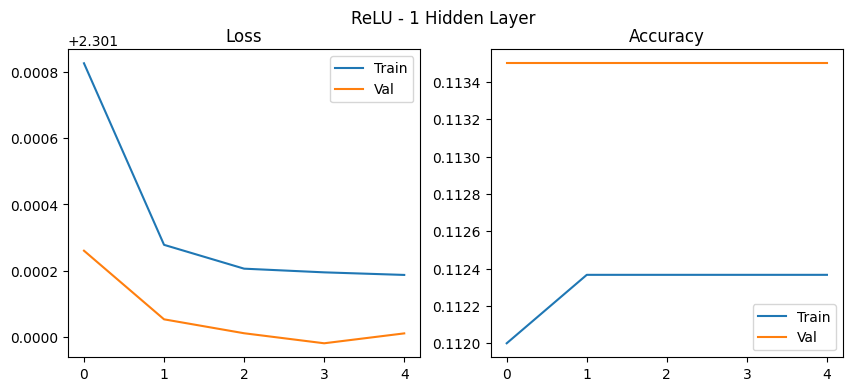

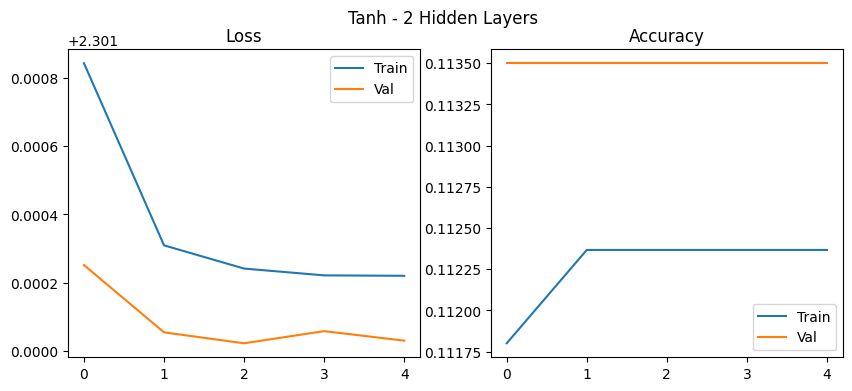

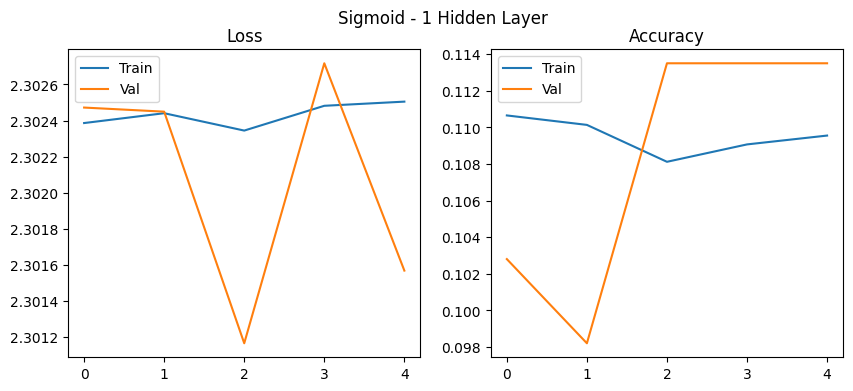

In [19]:
def plot_history(history, title):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Val')
    plt.title('Accuracy')
    plt.legend()
    plt.suptitle(title)
    plt.show()

plot_history(hist1, "ReLU - 1 Hidden Layer")
plot_history(hist2, "Tanh - 2 Hidden Layers")
plot_history(hist3, "Sigmoid - 1 Hidden Layer")